In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns




import random, os, sys
sys.path.append("../")


from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import tensorflow as tf


def metric(y_true, y_pred):
    res = []
    for i in range(0, y_true.shape[1]):
        y = y_true[:,i]
        pred = y_pred[:,i]
        res.append(log_loss(y, pred))
    return np.mean(res)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def make_scaler(flag):
    if flag == "quantile":
        return QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    elif flag == "standard":
        return StandardScaler()
    elif flag == "minmax":
        return MinMaxScaler()
    elif flag == "robust":
        return RobustScaler()
    
seeds = [0, 1, 2, 3, 4, 5, 6]
SCALE = "quantile"


def transformer(df1, df2, SCALE):
    for val in df1["time_dose"].unique():
        temp = pd.concat([df1[df1["time_dose"] == val], df2[df2["time_dose"] == val]])
        scaler = make_scaler(SCALE)
        scaler.fit(temp[BIOS].values.reshape(-1, len(BIOS)))
        tr_ind = df1[df1["time_dose"] == val].index
        te_ind = df2[df2["time_dose"] == val].index
        tr_trans = scaler.transform(df1[BIOS].iloc[tr_ind].values.reshape(-1, len(BIOS))).T
        te_trans = scaler.transform(df2[BIOS].iloc[te_ind].values.reshape(-1, len(BIOS))).T

        for i, col in enumerate(BIOS):
            df1[col].iloc[tr_ind] = tr_trans[i]
            df2[col].iloc[te_ind] = te_trans[i]
    return df1, df2




pd.set_option("display.max_columns", 1200)
pd.set_option("display.max_rows", 1200)

In [2]:
train_df = pd.read_csv("../../Data/Raw/train_features.csv")


test_df = pd.read_csv("../../Data/Raw/test_features.csv")
y = pd.read_csv("../../Data/Raw/train_targets_scored.csv")
y_non = pd.read_csv("../../Data/Raw/train_targets_nonscored.csv")

y_all = pd.merge(y, y_non, left_on="sig_id", right_on="sig_id")

y_true = y_all.drop("sig_id", axis=1).values

#train_all_df = pd.merge(train_df, y_all, left_on="sig_id", right_on="sig_id")
train_df = pd.merge(train_df, y, left_on="sig_id", right_on="sig_id")

GENES = [col for col in train_df.columns if col.startswith("g-")]
CELLS = [col for col in train_df.columns if col.startswith("c-")]
CELLS_50 = CELLS[:50]

BIOS = GENES + CELLS
MOAS = [col for col in y_all.columns if col != "sig_id"]
SCORED_MOAS = [col for col in y.columns if col != "sig_id"]

print(train_df.shape)
print(test_df.shape)
print(y.shape)
print(y_non.shape)
train_df["time_dose"] = train_df["cp_time"].astype(str) + " * " + train_df["cp_dose"]
test_df["time_dose"] = test_df["cp_time"].astype(str) + " * " + test_df["cp_dose"]

train_df, test_df = transformer(train_df, test_df, SCALE)

(23814, 1082)
(3982, 876)
(23814, 207)
(23814, 403)


In [3]:
train_df["tag"] = ""
for col in [col for col in y.columns if col != "sig_id"]:
    train_df["tag"] += y[col].astype("str")
print(train_df["tag"].unique().shape)

moa_dict = {}
for tag in train_df["tag"].unique():
    name = ""
    for i, col in enumerate(SCORED_MOAS):
        if tag[i] == '1':
            name += col
            name += " : "
    if len(name) == 0:
        name += "dont have moa : "
    name = name[:-3]
    moa_dict[tag] = name
train_df["tag"] = train_df["tag"].map(moa_dict)

#MOA の尻尾の文字
dic = {}
for moa in SCORED_MOAS:
    tail = moa.split("_")[-1]
    c = dic[tail] if tail in dic else 0
    dic[tail] = c+1

(328,)


In [ ]:
high_corr_cols = []
corrs = train_df[GENES].corr()
for i in range(0, corrs.shape[0]-1):
    for j in range(i+1, corrs.shape[0]):
        v = abs(corrs.iat[i, j])
        if v >= 0.8:
            high_corr_cols.append(corrs.index[i])
            break
            
corrs = train_df[CELLS].corr()
for i in range(0, corrs.shape[0]-1):
    for j in range(i+1, corrs.shape[0]):
        v = abs(corrs.iat[i, j])
        if v >= 0.9:
            high_corr_cols.append(corrs.index[i])
            break
            
BIOS = list(set(BIOS) - set(high_corr_cols))
GENES = [col for col in GENES if col in BIOS]
CELLS = [col for col in CELLS if col in BIOS]
train_df.drop(columns=high_corr_cols, inplace=True)

In [4]:
D1_24 = train_df[train_df["time_dose"] == "24 * D1"].reset_index()
D1_48 = train_df[train_df["time_dose"] == "48 * D1"].reset_index()
D1_72 = train_df[train_df["time_dose"] == "72 * D1"].reset_index()
D2_24 = train_df[train_df["time_dose"] == "24 * D2"].reset_index()
D2_48 = train_df[train_df["time_dose"] == "48 * D2"].reset_index()
D2_72 = train_df[train_df["time_dose"] == "72 * D2"].reset_index()

for df in [D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]:
    df["c-mean"] = 0
    df["g-mean"] = 0
    for tag in df["tag"].unique():
        df["c-mean"][df["tag"] == tag] = df[df["tag"] == tag][CELLS].mean(axis=1)
        df["g-mean"][df["tag"] == tag] = df[df["tag"] == tag][GENES].mean(axis=1)

In [5]:
moas_list = []
prob = 0.5
p_cols = []
for i, df in enumerate([D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]):
    print(i+1)
    for col in BIOS:
        temp = (df[df[col] >= 9.5]["tag"].value_counts()).div(df["tag"].value_counts(), fill_value=0)
        temp = temp[temp != 0].sort_values(ascending=False)
        if temp.shape[0] != 0 and temp[0] >= prob:
            for i, v in enumerate(temp):
                if v >= 0.5:
                    moas_list.append(temp.index[i])
            p_cols.append(col)
            
n_cols = []
for i, df in enumerate([D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]):
    print(i+1)
    for col in BIOS:
        temp = (df[df[col] <= -9.5]["tag"].value_counts()).div(df["tag"].value_counts(), fill_value=0)
        temp = temp[temp != 0].sort_values(ascending=False)
        if temp.shape[0] != 0 and temp[0] >= prob:
            for i, v in enumerate(temp):
                if v >= 0.5:
                    moas_list.append(temp.index[i])
            n_cols.append(col)
            
            
p_cols = list(set(p_cols))
n_cols = list(set(n_cols))
moas_list = list(set(moas_list))

1
2
3
4
5
6
1
2
3
4
5
6


In [6]:
train_df["tag"].value_counts()

dont have moa                                                                                                                                        9367
nfkb_inhibitor : proteasome_inhibitor                                                                                                                 718
cyclooxygenase_inhibitor                                                                                                                              374
glutamate_receptor_antagonist                                                                                                                         337
adrenergic_receptor_antagonist                                                                                                                        335
dna_inhibitor                                                                                                                                         330
cdk_inhibitor                                                               

In [7]:
# 特定のMoAについてはCELLSの平均が著しく下がる
tags = [
    "nfkb_inhibitor : proteasome_inhibitor",
    "proteasome_inhibitor",
    "mtor_inhibitor : pi3k_inhibitor",
    "cdk_inhibitor : flt3_inhibitor : jak_inhibitor",
    "apoptosis_stimulant : bcl_inhibitor : ikk_inhibitor : nfkb_inhibitor : nitric_oxide_production_inhibitor : nrf2_activator : ppar_receptor_agonist",
    
]

for df in [D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]:
    for tag in tags:
        temp = df[df["tag"] == tag][CELLS].mean().mean()
        print("{} : {}".format(tag, temp))
    print()

nfkb_inhibitor : proteasome_inhibitor : -2.1423724892892313
proteasome_inhibitor : -1.6381997576238831
mtor_inhibitor : pi3k_inhibitor : -1.7228000144883102
cdk_inhibitor : flt3_inhibitor : jak_inhibitor : -1.829425533541421
apoptosis_stimulant : bcl_inhibitor : ikk_inhibitor : nfkb_inhibitor : nitric_oxide_production_inhibitor : nrf2_activator : ppar_receptor_agonist : -3.15555055251102

nfkb_inhibitor : proteasome_inhibitor : -2.888012736428908
proteasome_inhibitor : -2.35266476197627
mtor_inhibitor : pi3k_inhibitor : -1.7800845957396887
cdk_inhibitor : flt3_inhibitor : jak_inhibitor : -2.051720659182125
apoptosis_stimulant : bcl_inhibitor : ikk_inhibitor : nfkb_inhibitor : nitric_oxide_production_inhibitor : nrf2_activator : ppar_receptor_agonist : -3.5154128530903894

nfkb_inhibitor : proteasome_inhibitor : -3.314174113899568
proteasome_inhibitor : -2.882345088580978
mtor_inhibitor : pi3k_inhibitor : -1.742826345274492
cdk_inhibitor : flt3_inhibitor : jak_inhibitor : -2.12819637364

In [8]:
D1_24.groupby("tag").mean()[CELLS + ["c-mean"]].sort_values("c-mean")

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,c-40,c-41,c-42,c-43,c-44,c-45,c-46,c-47,c-48,c-49,c-50,c-51,c-52,c-53,c-54,c-55,c-56,c-57,c-58,c-59,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,c-mean
tag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
apoptosis_stimulant : bcl_inhibitor : ikk_inhibitor : nfkb_inhibitor : nitric_oxide_production_inhibitor : nrf2_activator : ppar_receptor_agonist,-2.763083,-2.815446,-2.897302,-2.359220,-2.291093,-3.417202,-2.146492,-2.876078,-3.326170,-2.031990,-3.118182,-2.876495,-2.379084,-2.837219,-2.437963,-2.322850,-3.547137,-2.421044,-2.982943,-2.615324,-2.885618,-3.209590,-2.054568,-1.768446,-2.905032,-2.849934,-2.913472,-2.535998,-1.843329,-1.978110,-2.392336,-2.789497,-2.489643,-2.099200,-3.257537,-2.415050,-3.391772,-2.212469,-2.036602,-2.980186,-2.420903,-3.316947,-2.708150,-3.313508,-3.178542,-2.583564,-3.232294,-5.199338,-3.308380,-2.440349,-2.531287,-2.336973,-2.131630,-2.514005,-2.436896,-5.199338,-5.199338,-2.638990,-2.210194,-5.199338,-5.199338,-2.315308,-2.282610,-5.199338,-5.199338,-5.199338,-2.349836,-2.059150,-3.253970,-2.572120,-5.199338,-2.569843,-5.199338,-5.199338,-2.355326,-5.199338,-1.808890,-5.199338,-5.199338,-2.432246,-5.199338,-2.486033,-5.199338,-5.199338,-2.694202,-3.045312,-2.940256,-2.569784,-2.829649,-5.199338,-2.516021,-2.337599,-1.919336,-5.199338,-5.199338,-2.527264,-5.199338,-2.628409,-2.706532,-2.395950,-3.155551
nfkb_inhibitor : proteasome_inhibitor,-2.099643,-2.147073,-2.162714,-1.999783,-2.170088,-2.006050,-2.387091,-2.062576,-2.081950,-2.129324,-2.072071,-2.177583,-2.160334,-2.145653,-2.120316,-2.049378,-2.111193,-2.321630,-2.050618,-1.925824,-2.008272,-2.073342,-0.853077,-2.158232,-2.061101,-1.916737,-2.323111,-2.100922,-2.197946,-2.113800,-2.194423,-2.393793,-2.115637,-3.211363,-1.939216,-2.128386,-2.055220,-2.184154,-3.188937,-2.132247,-2.123716,-1.956574,-2.212010,-2.013369,-2.225527,-2.453771,-2.114576,-1.978039,-1.994150,-1.974013,-1.826276,-2.078046,-2.203142,-2.121831,-2.121708,-2.259868,-1.954355,-1.942609,-1.979868,-2.090232,-2.507119,-2.095344,-2.127826,-2.511250,-1.867431,-2.240530,-2.090215,-2.168331,-2.089989,-2.148423,-2.824392,-2.091611,-2.189436,-2.051248,-2.111045,-2.225059,-2.159175,-2.472372,-2.153380,-2.005655,-2.014635,-2.078999,-2.110878,-2.266835,-2.006764,-2.152508,-1.950527,-1.894375,-2.111252,-2.015501,-2.287420,-2.187667,-2.128311,-3.052180,-2.208496,-1.913535,-2.288189,-2.099912,-2.030220,-1.954727,-2.142372
flt3_inhibitor : kit_inhibitor : pdgfr_inhibitor : vegfr_inhibitor,-1.906051,-1.704637,-1.716932,-1.112241,-1.501481,-1.694372,-1.313804,-1.738000,-1.875975,-2.300695,-1.856840,-1.510447,-2.218868,-1.743017,-1.788411,-2.701574,-1.490185,-1.747271,-1.662096,-2.424418,-2.322400,-2.011615,-2.991384,-1.630351,-2.755440,-1.892520,-1.798116,-1.563661,-2.064845,-1.746319,-1.724560,-1.732555,-1.714599,-1.313078,-5.199338,-1.796905,-2.440055,-1.993836,-5.199338,-0.718366,-1.590665,-1.404438,-1.664473,-1.694746,-1.745586,-5.199338,-1.833061,-2.046191,-1.661927,-2.422992,-2.428223,-1.514891,-1.564375,-1.779211,-1.663118,-0.481614,-2.331841,-2.449800,-2.362359,-1.828035,-2.049041,-0.844764,-1.728039,-2.322390,-2.356280,-2.130167,-1.663355,-1.671675,-2.806558,-1.961558,-1.844930,-1.681287,-1.694020,-1.592123,-1.658023,-1.443279,-1.685515,-5.199338,-1.866255,-1.590781,-1.853634,-1.188763,-1.519550,-1.649797,-1.286293,-1.726533,-3.019807,-1.853494,-2.175463,-2.133615,-1.515753,-2.154906,-1.689270,-5.199338,-2.160262,-1.853259,-1.543408,-1.826072,-2.559868,-2.443405,-2.014253
bacterial_membrane_integrity_inhibitor,-2.095791,-1.639477,-1.646700,-2.340539,-1.744697,-1.816047,-1.673161,-1.6649

In [9]:
plot_col = "kit_inhibitor"
for col in train_df["tag"].unique():
    if plot_col in col:
        print(col, train_df[train_df["tag"] == col].shape[0])

bcr-abl_inhibitor : kit_inhibitor : pdgfr_inhibitor 7
flt3_inhibitor : kit_inhibitor : pdgfr_inhibitor 192
kit_inhibitor : pdgfr_inhibitor : vegfr_inhibitor 25
bcr-abl_inhibitor : kit_inhibitor : pdgfr_inhibitor : src_inhibitor : tyrosine_kinase_inhibitor 6
kit_inhibitor : pdgfr_inhibitor 6
fgfr_inhibitor : kit_inhibitor : pdgfr_inhibitor : vegfr_inhibitor 6
kit_inhibitor 6
kit_inhibitor : pdgfr_inhibitor : src_inhibitor 6
flt3_inhibitor : kit_inhibitor : pdgfr_inhibitor : raf_inhibitor : vegfr_inhibitor 6
flt3_inhibitor : kit_inhibitor : pdgfr_inhibitor : vegfr_inhibitor 6
fgfr_inhibitor : kit_inhibitor : pdgfr_inhibitor : raf_inhibitor : vegfr_inhibitor 1
flt3_inhibitor : kit_inhibitor : pkc_inhibitor 6


<AxesSubplot:>

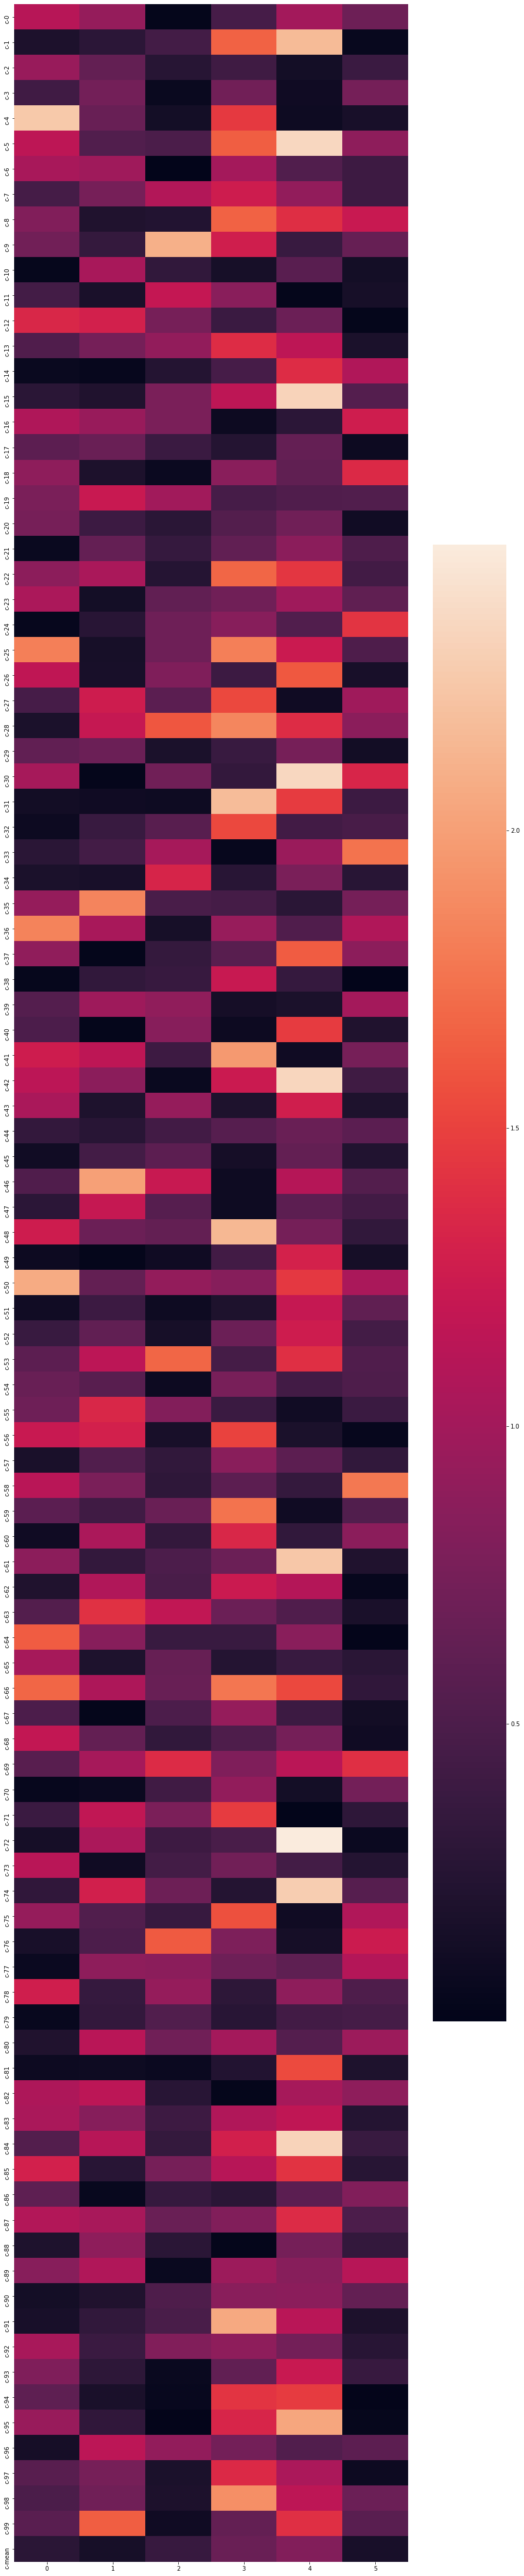

In [10]:
#D1_24.groupby(["cyclooxygenase_inhibitor", "lipoxygenase_inhibitor"]).mean()[GENES + ["g-mean"]]
li = []
#for df in [D1_24, D1_48, D1_72]:
#plotter = GENES+["g-mean"]
plotter = CELLS+["c-mean"]

for df in [D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]:
#for df in [D2_24, D1_24, D2_48, D1_48, D2_72, D1_72]:
    temp = df[df["tag"] == plot_col][plotter].mean()
    temp2 = df[df["tag"] == "dont have moa"][plotter].mean()
    li.append(abs(temp - temp2))
tmp = pd.concat(li, axis=1)
plt.figure(figsize=(15, 80))
sns.heatmap(tmp)




In [31]:
ans_di = {}
plotter = GENES
for tag in train_df["tag"].unique():
    print(tag)
    me_li = []
    va_li = []
    di = {}
    g_di = {}
    li = []
    if train_df[train_df["tag"] == tag].shape[0] <= 30 or tag == "dont have moa":
        continue
    for df in [D1_24, D1_48, D1_72, D2_24, D2_48, D2_72]:
        temp = df[df["tag"] == tag][plotter].mean()
        temp2 = df[df["tag"] == "dont have moa"][plotter].mean()
        li.append(abs(temp - temp2))
    tmp = pd.concat(li, axis=1)
    for g in GENES:
        me = tmp.loc[g].mean()
        va = tmp.loc[g].var()
        me_li.append(me)
        va_li.append(va)
        di[me] = va
        g_di[me] = g
    me_li.sort(reverse=True)
    va_li.sort()
    ans_di[tag] = [ g_di[me] for me in me_li[:15] if di[me] <= va_li[350] ]
    
        
    

gsk_inhibitor
dont have moa
bcr-abl_inhibitor : kit_inhibitor : pdgfr_inhibitor
calcium_channel_blocker
cdk_inhibitor
pdk_inhibitor
rho_associated_kinase_inhibitor
dopamine_receptor_antagonist : gaba_receptor_agonist
neuropeptide_receptor_antagonist
dna_inhibitor
prostanoid_receptor_antagonist
nfkb_inhibitor : proteasome_inhibitor
hdac_inhibitor
aurora_kinase_inhibitor : bcr-abl_inhibitor : flt3_inhibitor : jak_inhibitor
serotonin_receptor_agonist
acetylcholine_receptor_agonist : gaba_receptor_agonist
progesterone_receptor_agonist
bcr-abl_inhibitor
glucocorticoid_receptor_agonist
cyclooxygenase_inhibitor : prostaglandin_inhibitor
pdgfr_inhibitor
aromatase_inhibitor
cyclooxygenase_inhibitor
serotonin_receptor_antagonist
histamine_receptor_antagonist
egfr_inhibitor
pi3k_inhibitor
sodium_channel_inhibitor
flt3_inhibitor : kit_inhibitor : pdgfr_inhibitor
fgfr_inhibitor
cytochrome_p450_inhibitor
acetylcholine_receptor_antagonist
bacterial_antifolate
acetylcholine_receptor_agonist
dopamine_r

In [36]:
ans_di.values()

dict_values([['g-616', 'g-48'], [], ['g-432', 'g-360', 'g-135', 'g-257', 'g-503', 'g-664', 'g-486', 'g-498', 'g-491', 'g-433', 'g-761'], ['g-443', 'g-566', 'g-615'], ['g-597', 'g-256'], ['g-90'], [], ['g-406'], ['g-525', 'g-272'], ['g-235'], ['g-392', 'g-708', 'g-689'], ['g-122', 'g-175', 'g-202'], ['g-547'], ['g-392', 'g-423', 'g-122'], ['g-302'], ['g-27', 'g-10', 'g-266'], ['g-635', 'g-745', 'g-108', 'g-626', 'g-0', 'g-8'], ['g-392', 'g-229', 'g-117', 'g-718'], ['g-566'], ['g-424', 'g-207', 'g-39', 'g-768', 'g-317'], [], ['g-392', 'g-206', 'g-600'], ['g-466', 'g-449'], ['g-2'], ['g-392', 'g-90', 'g-113', 'g-744', 'g-135', 'g-353', 'g-91', 'g-65', 'g-724', 'g-414'], ['g-443', 'g-322', 'g-211'], ['g-753', 'g-7', 'g-401', 'g-593', 'g-291'], [], ['g-178', 'g-435'], ['g-322', 'g-206'], ['g-27', 'g-600'], ['g-431', 'g-522', 'g-75', 'g-207', 'g-119', 'g-279', 'g-22', 'g-47', 'g-167', 'g-102', 'g-769', 'g-221'], [], [], ['g-104', 'g-587'], [], ['g-322', 'g-142'], ['g-569', 'g-690'], ['g-450'

In [37]:
g_li = [['g-616', 'g-48'], [], ['g-432', 'g-360', 'g-135', 'g-257', 'g-503', 'g-664', 'g-486', 'g-498', 'g-491', 'g-433', 'g-761'], ['g-443', 'g-566', 'g-615'], ['g-597', 'g-256'], ['g-90'], [], ['g-406'], ['g-525', 'g-272'], ['g-235'], ['g-392', 'g-708', 'g-689'], ['g-122', 'g-175', 'g-202'], ['g-547'], ['g-392', 'g-423', 'g-122'], ['g-302'], ['g-27', 'g-10', 'g-266'], ['g-635', 'g-745', 'g-108', 'g-626', 'g-0', 'g-8'], ['g-392', 'g-229', 'g-117', 'g-718'], ['g-566'], ['g-424', 'g-207', 'g-39', 'g-768', 'g-317'], [], ['g-392', 'g-206', 'g-600'], ['g-466', 'g-449'], ['g-2'], ['g-392', 'g-90', 'g-113', 'g-744', 'g-135', 'g-353', 'g-91', 'g-65', 'g-724', 'g-414'], ['g-443', 'g-322', 'g-211'], ['g-753', 'g-7', 'g-401', 'g-593', 'g-291'], [], ['g-178', 'g-435'], ['g-322', 'g-206'], ['g-27', 'g-600'], ['g-431', 'g-522', 'g-75', 'g-207', 'g-119', 'g-279', 'g-22', 'g-47', 'g-167', 'g-102', 'g-769', 'g-221'], [], [], ['g-104', 'g-587'], [], ['g-322', 'g-142'], ['g-569', 'g-690'], ['g-450'], ['g-241'], ['g-335'], [], [], ['g-206'], ['g-91', 'g-90'], ['g-606', 'g-484'], ['g-731', 'g-105'], ['g-596'], ['g-537', 'g-479'], ['g-446'], ['g-739'], ['g-466', 'g-38'], [], [], ['g-482', 'g-197', 'g-122'], ['g-150', 'g-29', 'g-570', 'g-58', 'g-764'], ['g-48'], ['g-466', 'g-428'], ['g-699', 'g-207', 'g-594', 'g-614', 'g-124', 'g-150', 'g-409', 'g-179', 'g-146', 'g-616', 'g-492'], ['g-70', 'g-628'], ['g-153'], ['g-75', 'g-696', 'g-431', 'g-102', 'g-207', 'g-697'], ['g-546', 'g-524', 'g-470'], ['g-628', 'g-701', 'g-376'], ['g-381', 'g-718', 'g-642'], ['g-417'], ['g-355'], ['g-94', 'g-636', 'g-335'], ['g-402', 'g-133'], ['g-368', 'g-481'], ['g-357'], ['g-122', 'g-210', 'g-206'], ['g-500'], ['g-355', 'g-201', 'g-50', 'g-63'], ['g-84', 'g-392', 'g-135'], ['g-615', 'g-417'], ['g-594'], ['g-362'], [], ['g-344', 'g-82', 'g-351'], ['g-134'], ['g-421'], ['g-29', 'g-47', 'g-670', 'g-117', 'g-525', 'g-36'], ['g-153', 'g-740', 'g-138'], ['g-601', 'g-664'], ['g-138', 'g-170', 'g-414', 'g-17', 'g-75', 'g-84', 'g-117'], ['g-405', 'g-583', 'g-367'], ['g-699', 'g-492', 'g-174', 'g-165', 'g-150', 'g-664', 'g-48', 'g-323', 'g-290', 'g-410', 'g-720', 'g-724', 'g-81'], [], ['g-75', 'g-178'], [], ['g-470', 'g-311', 'g-200'], [], ['g-392', 'g-175', 'g-593', 'g-14'], ['g-60', 'g-497'], ['g-169', 'g-29'], ['g-623', 'g-394', 'g-465'], ['g-533'], [], ['g-373'], ['g-392', 'g-175'], ['g-329', 'g-574', 'g-536', 'g-206'], [], ['g-431', 'g-128', 'g-75', 'g-187'], ['g-258', 'g-630', 'g-226'], ['g-36', 'g-675', 'g-207', 'g-761', 'g-554', 'g-59'], ['g-345', 'g-489']]
g_li.remove([])

In [39]:
while [] in g_li:
    g_li.remove([])

In [40]:
g_li

[['g-616', 'g-48'],
 ['g-432',
  'g-360',
  'g-135',
  'g-257',
  'g-503',
  'g-664',
  'g-486',
  'g-498',
  'g-491',
  'g-433',
  'g-761'],
 ['g-443', 'g-566', 'g-615'],
 ['g-597', 'g-256'],
 ['g-90'],
 ['g-406'],
 ['g-525', 'g-272'],
 ['g-235'],
 ['g-392', 'g-708', 'g-689'],
 ['g-122', 'g-175', 'g-202'],
 ['g-547'],
 ['g-392', 'g-423', 'g-122'],
 ['g-302'],
 ['g-27', 'g-10', 'g-266'],
 ['g-635', 'g-745', 'g-108', 'g-626', 'g-0', 'g-8'],
 ['g-392', 'g-229', 'g-117', 'g-718'],
 ['g-566'],
 ['g-424', 'g-207', 'g-39', 'g-768', 'g-317'],
 ['g-392', 'g-206', 'g-600'],
 ['g-466', 'g-449'],
 ['g-2'],
 ['g-392',
  'g-90',
  'g-113',
  'g-744',
  'g-135',
  'g-353',
  'g-91',
  'g-65',
  'g-724',
  'g-414'],
 ['g-443', 'g-322', 'g-211'],
 ['g-753', 'g-7', 'g-401', 'g-593', 'g-291'],
 ['g-178', 'g-435'],
 ['g-322', 'g-206'],
 ['g-27', 'g-600'],
 ['g-431',
  'g-522',
  'g-75',
  'g-207',
  'g-119',
  'g-279',
  'g-22',
  'g-47',
  'g-167',
  'g-102',
  'g-769',
  'g-221'],
 ['g-104', 'g-587'],


1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5


absでみて、そのあと確認しよう
D1の時のg-392, g-443, g-50, g-146, g-406, g-503, g-672, g-683, g-723, g-744
D1-24 g-513
D1−72のときc-63とc-65が以上に高い、

dopamine_receptor_antagonist
g-157, g-178

serotonin_receptor_antagonist
g-322,g−422

glutamate_receptor_antagonist
D1, g-761, g-322, g-10
g-554, g-522

adrenergic_receptor_antagonist
g-636

dna_inhibitor
g_90, g-91, g-206, g-270, g-437, g-36, g-512, g-768

In [ ]:
print(tmp.loc["g-36"].mean())
print(tmp.loc["g-36"].var())

In [ ]:
print(tmp.loc["g-65"].mean())
print(tmp.loc["g-65"].var())

In [ ]:
from scipy.spatial import distance
X = D1_24[BIOS].values

correct_dict = {}

tag_li = []

for i in range(0, X.shape[0]):
#for i in range(0, 100):        
    di = {}
    moa_i =  D1_24["tag"][i]
    if moa_i == "dont have moa":
        continue
    for j in range(0, X.shape[0]):
        if D1_24["tag"].iloc[j] == "dont have moa" or i == j:
            continue
        moa_j = D1_24["tag"][j]
        d = distance.euclidean(X[i], X[j])
        di[d] = [j, moa_j]
    li = sorted(di)
    
    try:
        #print("{}, {}".format(i, moa_i))
        #print(di[li[0]][1])
        #print(di[li[1]][1])
        #print(di[li[2]][1])
        #print()
        if moa_i == di[li[0]][1] == di[li[1]][1] == di[li[2]][1] == di[li[3]][1] == di[li[4]][1]:
            tag_li.append(D1_24.iloc[i]["index"])
            print(i," ",  D1_24.iloc[i]["index"], " all")
            print(moa_i)
            
        #elif moa_i == di[li[0]][1] == di[li[1]][1]:
            #print(i, " 1 and 2")
            #print(moa_i)
    except:
        pass


In [ ]:
train_df["cyclooxygenase_inhibitor"].sum()

In [ ]:
p = 0.001
t = 0
def func:
    
    -(t*np.log(p) + (1-t) * np.log(1-p))

In [ ]:
y[:,0].shape

In [ ]:
y[:,0].shape

In [ ]:
#c-22, c-23, c-36, c-44, c-56, c-61, c-64, c-86, c-95, c-96
#c-78, c-32, 
temp1 = D1_72[D1_72["tag"] == tags[0]][CELLS].mean()
temp2 = D1_72[D1_72["tag"] == tags[4]][CELLS].mean()
temp3 = temp1 - temp2
pd.concat([temp1, temp2, temp3], axis=1).T